## 라이브러리 임포트

- `os`, `cv2`: 파일 관리 및 이미지 입출력
- `numpy`: 배열 연산
- `torch`: 딥러닝 프레임워크
- `torchvision.transforms`: 이미지 전처리
- `PIL.Image`: 이미지 변환
- `matplotlib.pyplot`: 시각화

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from PIL import Image, ImageEnhance, ImageFilter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import v2
import math
import torchvision.transforms.functional as TF
import torch.nn.functional as F

## 코드 실행

GPU 설정합니다

In [ ]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 코드 실행

구글 드라이브를 연결합니다

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# sys.path에 추가 (예시: MyDrive/utils/ 폴더에 저장)
import sys
sys.path.append("/content/drive/MyDrive/toss/data")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 로딩 함수 정의

폴더 내 `.png` 이미지를 읽어서 RGB 형식으로 리스트에 담습니다.

In [ ]:
# 폴더 경로 설정
train_dir = "/content/drive/MyDrive/colab/project5/train"
train_cleaned_dir = "/content/drive/MyDrive/colab/project5/train_cleaned"
test_dir = "/content/drive/MyDrive/colab/project5/test"

# 이미지 파일 읽기 함수
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):  # PNG 파일만 가져오기
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)  # OpenCV로 이미지를 읽음 (BGR 형식)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환
            images.append(img)
    return images

# 이미지 불러오기
train_images = load_images_from_folder(train_dir)
train_cleaned_images = load_images_from_folder(train_cleaned_dir)
test_images = load_images_from_folder(test_dir)

# 결과 출력

print(f"Train: {len(train_images)}")
print(f"Train Cleaned: {len(train_cleaned_images)}")
print(f"Test: {len(test_images)}")

Train: 144
Train Cleaned: 144
Test: 72


## 코드 실행

각 데이터들의 이미지 크기를 출력합니다

In [ ]:
# 각 데이터셋의 이미지 크기 추출
train_sizes = [img.shape[:2] for img in train_images]  # train 이미지의 크기 (height, width)
train_cleaned_sizes = [img.shape[:2] for img in train_cleaned_images]  # train_cleaned 이미지의 크기
test_sizes = [img.shape[:2] for img in test_images]  # test 이미지의 크기

# 유니크한 이미지 크기 계산
train_unique_sizes = np.unique(train_sizes, axis=0)  # train 이미지의 유니크 크기
train_cleaned_unique_sizes = np.unique(train_cleaned_sizes, axis=0)  # train_cleaned 유니크 크기
test_unique_sizes = np.unique(test_sizes, axis=0)  # test 유니크 크기

# 결과 출력
print("Unique sizes in train:\n", train_unique_sizes)
print("Unique sizes in train_cleaned:\n", train_cleaned_unique_sizes)
print("Unique sizes in test:\n", test_unique_sizes)

Unique sizes in train:
 [[258 540]
 [420 540]]
Unique sizes in train_cleaned:
 [[258 540]
 [420 540]]
Unique sizes in test:
 [[258 540]
 [420 540]]


## 모델 클래스 정의

여러 이미지들의 사이즈를 동일하기 맞추기 위해 필요한 패딩수를 계산합니다


In [ ]:
class PadToSize:
    def __init__(self, target_size):
        self.target_size = target_size  # (높이, 너비)

    def __call__(self, img):
        # 텐서 크기 가져오기 (C, H, W 형식)
        _, height, width = img.shape
        target_height, target_width = self.target_size

        # 패딩 계산
        pad_top = (target_height - height) // 2
        pad_bottom = target_height - height - pad_top
        pad_left = (target_width - width) // 2
        pad_right = target_width - width - pad_left

        # 패딩 적용
        return TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=0)

## 모델 클래스 정의

그레이스케일 클래스를 정의합니다

In [ ]:
class Grayscale:
    def __call__(self, img):
        """
        RGB 이미지를 그레이스케일로 변환하는 클래스
        :param img: 입력 이미지 (PIL 또는 Tensor)
        :return: 그레이스케일 변환된 이미지 (Tensor)
        """
        # Tensor -> PIL 이미지로 변환
        pil_img = TF.to_pil_image(img) if isinstance(img, torch.Tensor) else img

        # 그레이스케일 변환
        grayscale_img = pil_img.convert("L")  # RGB -> Grayscale

        # PIL -> Tensor 변환
        return TF.to_tensor(grayscale_img)

## Dataset 클래스 정의

numpy 배열 형태의 이미지를 PyTorch 학습에 맞게 Dataset으로 감싸줍니다.
- 그레이스케일
- 리사이즈 및 텐서 변환
- (img, img) 형태 반환 → AutoEncoder 입력=출력

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = sorted(
            [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.png')]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')  # RGB로 열기

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
class PairedImageDataset(Dataset):
    def __init__(self, train_dir, train_cleaned_dir, transform=None):
        """
        두 개의 디렉토리에서 이미지를 로드하고 매칭.
        :param train_dir: 원본 이미지 디렉토리
        :param train_cleaned_dir: 정제된 이미지 디렉토리
        :param transform: 원본 이미지에 적용할 데이터 변환
        :param transform_cleaned: 정제된 이미지에 적용할 데이터 변환
        """
        self.train_files = sorted(
            [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith('.png')]
        )
        self.cleaned_files = sorted(
            [os.path.join(train_cleaned_dir, f) for f in os.listdir(train_cleaned_dir) if f.endswith('.png')]
        )
        assert len(self.train_files) == len(self.cleaned_files), "train과 cleaned 데이터셋의 크기가 다릅니다."
        self.transform = transform

    def __len__(self):
        return len(self.train_files)

    def __getitem__(self, idx):
        # 원본 이미지
        train_img = Image.open(self.train_files[idx]).convert('RGB')
        # 정제된 이미지
        cleaned_img = Image.open(self.cleaned_files[idx]).convert('RGB')

        # 변환 적용
        if self.transform:
            train_img = self.transform(train_img)
            cleaned_img = self.transform(cleaned_img)

        return train_img, cleaned_img

In [ ]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        PadToSize((420, 540)),  # 패딩 적용
        v2.ToDtype(dtype=torch.float32, scale=True),  # 데이터 타입 변경 및 정규화
        Grayscale(),  # 그레이스케일 변환
    ]
)

## 코드 실행

DataLoader를 생성하고 train데이터와 cleaned_train데이터에서 이미지를 출력합니다.

In [ ]:
# 데이터셋 생성
paired_dataset = PairedImageDataset(train_dir, train_cleaned_dir, transforms)
test_dataset = ImageDataset(test_dir, transforms)

# DataLoader 생성
paired_loader = DataLoader(paired_dataset, batch_size=16, shuffle=True)  # shuffle=True로 배치를 섞을 수 있음
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

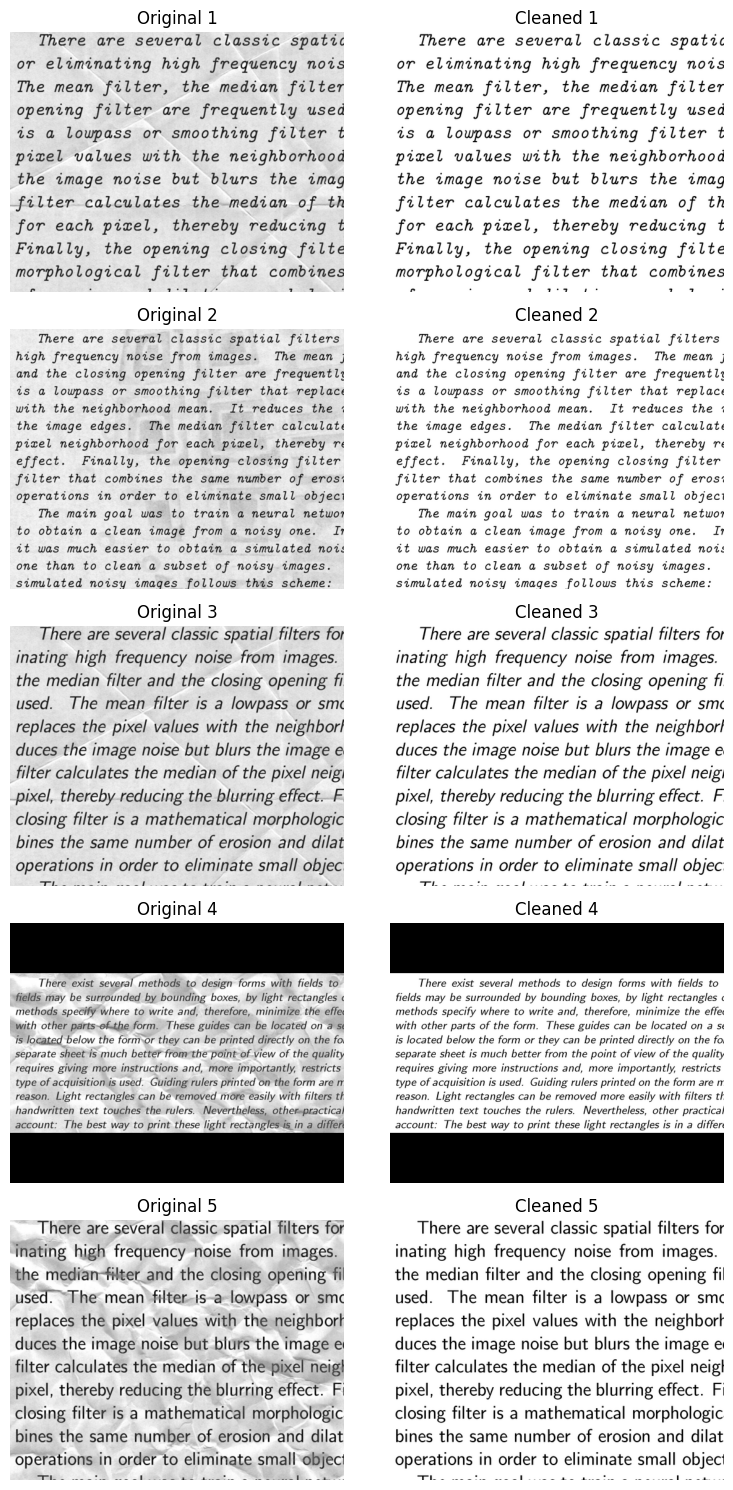

In [ ]:
def visualize_paired_dataset(paired_loader, num_images=5):
    # paired_loader에서 데이터 하나 가져오기
    for train_images, cleaned_images in paired_loader:
        # 시각화
        fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 3))  # num_images 행, 2열 (위: train, 아래: cleaned)
        for i in range(num_images):
            # 첫 번째 열: 원본 이미지 (train)
            axes[i, 0].imshow(train_images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')  # [C, H, W] -> [H, W, C]
            axes[i, 0].set_title(f"Original {i+1}")
            axes[i, 0].axis('off')  # 축 비활성화

            # 두 번째 열: 정제된 이미지 (cleaned)
            axes[i, 1].imshow(cleaned_images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')  # [C, H, W] -> [H, W, C]
            axes[i, 1].set_title(f"Cleaned {i+1}")
            axes[i, 1].axis('off')  # 축 비활성화

        plt.tight_layout()
        plt.show()
        break  # 한 번만 실행하도록 break

# PairedImageDataset에서 이미지 위아래 시각화
visualize_paired_dataset(paired_loader, num_images=5)

# 오토인코더


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # 인코더
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=4),  # 420x540 -> 210x270
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=3),  # 210x270 -> 105x135
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=2),  # 105x135 -> 53x68
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 53x68 -> 27x34
            # nn.ReLU(),
            # nn.BatchNorm2d(512)
        )

        # 디코더
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 27x34 -> 53x68
            # nn.ReLU(),
            # nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=2, output_padding=1),  # 53x68 -> 105x135
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=3, output_padding=1),   # 105x135 -> 210x270
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=4, output_padding=1),     # 210x270 -> 420x540
            nn.Sigmoid()  # 픽셀 값 [0, 1]로 정규화
        )

    def forward(self, x):
        # 인코딩
        encoded = self.encoder(x)

        # 디코딩
        decoded = self.decoder(encoded)

        # 최종 크기 맞춤
        resized_output = F.interpolate(decoded, size=(420, 540), mode='bilinear', align_corners=False)
        return resized_output

# 모델생성

In [ ]:
model = DenoisingAutoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

## 학습 루프

모델을 지정된 Epoch 수만큼 학습시킵니다.
- Forward → 손실 계산 → Backward → Optimizer step
- Epoch마다 평균 손실을 출력합니다.

In [ ]:
# 모델 학습
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for train_images, cleaned_images in paired_loader:  # paired_loader에서 가져오기
        # 데이터를 GPU로 전송
        train_images = train_images.to(device)
        cleaned_images = cleaned_images.to(device)

        # 모델 예측 및 손실 계산
        outputs = model(train_images)
        loss = loss_fn(outputs, cleaned_images)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 손실 누적
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(paired_loader):.4f}")

Epoch [1/20], Loss: 0.1460
Epoch [2/20], Loss: 0.0416
Epoch [3/20], Loss: 0.0233
Epoch [4/20], Loss: 0.0154
Epoch [5/20], Loss: 0.0125
Epoch [6/20], Loss: 0.0121
Epoch [7/20], Loss: 0.0104
Epoch [8/20], Loss: 0.0085
Epoch [9/20], Loss: 0.0093
Epoch [10/20], Loss: 0.0087
Epoch [11/20], Loss: 0.0084
Epoch [12/20], Loss: 0.0059
Epoch [13/20], Loss: 0.0047
Epoch [14/20], Loss: 0.0046
Epoch [15/20], Loss: 0.0072
Epoch [16/20], Loss: 0.0059
Epoch [17/20], Loss: 0.0052
Epoch [18/20], Loss: 0.0046
Epoch [19/20], Loss: 0.0057
Epoch [20/20], Loss: 0.0044


In [ ]:
# 테스트
model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device) # 원본 이미지
        outputs = model(images) # 출력
        break

## 모델 테스트

테스트 데이터로 모델을 테스트 합니다.

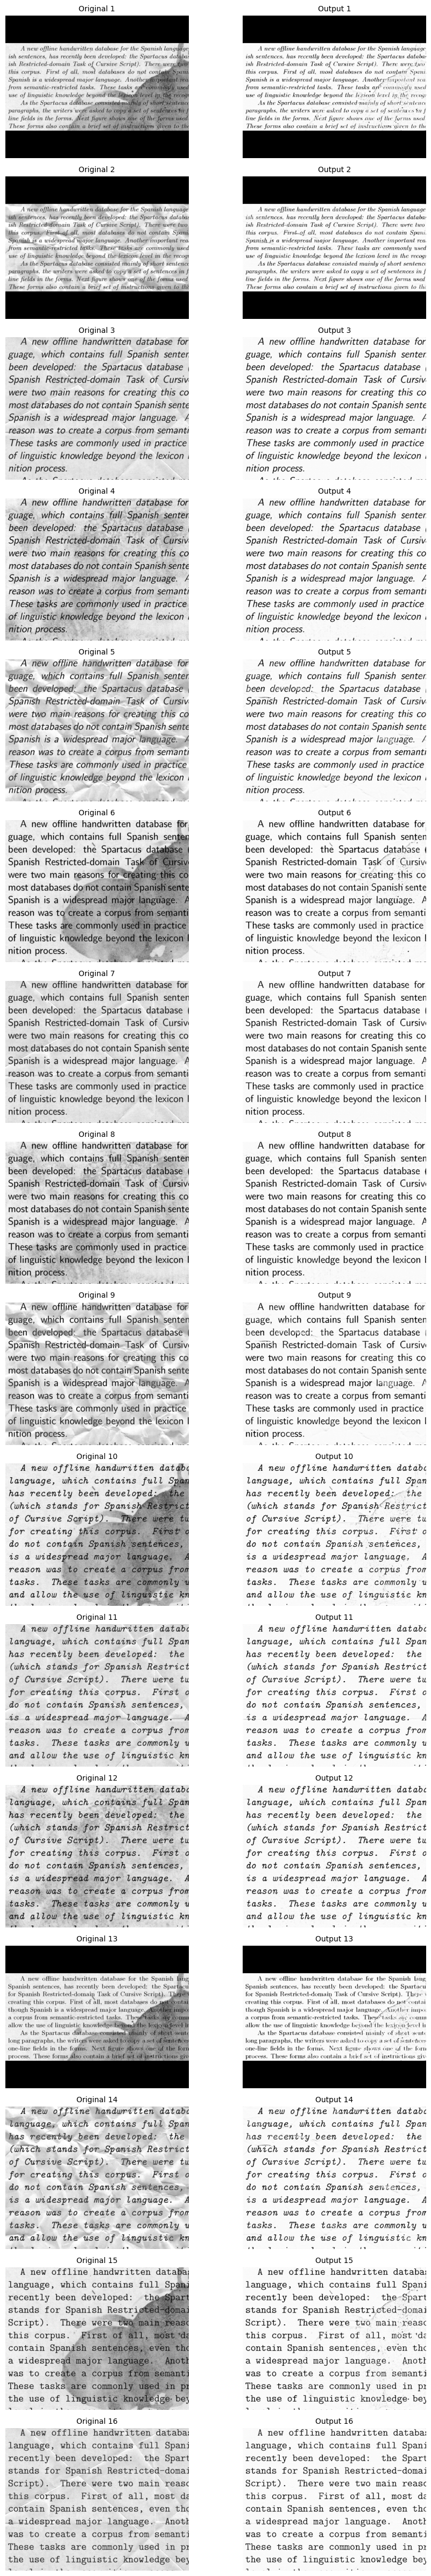

In [ ]:
def visualize_images_and_outputs(images, outputs):
    """
    이미지와 출력 이미지를 열로 구분하여 시각화.
    :param images: 원본 이미지 텐서
    :param outputs: 모델 출력 텐서
    """
    num_images = images.size(0)  # 전체 이미지 개수
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))  # num_images 행, 2열

    for i in range(num_images):
        # 첫 번째 열: 원본 이미지
        axes[i, 0].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Original {i + 1}", fontsize=10)
        axes[i, 0].axis('off')

        # 두 번째 열: 출력 이미지
        axes[i, 1].imshow(outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Output {i + 1}", fontsize=10)
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_and_outputs(images, outputs)